# 07.2b: Equatorial Wedge Plot

**Goal:** Visualize radial structure in a longitudinal wedge of the equatorial plane.

This notebook projects vectors onto the equatorial (X,Y) plane and displays them in polar coordinates:
- **Radial axis:** Distance from viewpoint (r = ||vector||)
- **Angular axis:** Longitude in specified FOV window
- **Color:** Height above/below equatorial plane (Z-component) or custom scalar field

Perfect for exploring radial structure (shells, filaments, clusters) in specific sky regions.

**Coordinate convention (right-hand rule):**
- +Z = North (out of equatorial plane)
- +X = Meridian (0° longitude)
- +Y = Equinox (90° longitude)

## Parameters

In [809]:
# ============================================================================
# REQUIRED DATA
# ============================================================================

TENSOR_DIR = "../data/tensors"

# Input vectors
VECTORS_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
VECTORS_KEY = "gamma"

# Basis vectors (defines coordinate system)
BASIS_FILE = "pca_basis_vectors.safetensors"
BASIS_KEYS = {
    'north': '1',      # +Z: north (out of equatorial plane)
    'meridian': '2',   # +X: prime meridian (0° lon)
    'equinox': '3'     # +Y: equinox (90° lon)
}

# ============================================================================
# OPTIONAL DATA
# ============================================================================

# Viewpoint (origin for polar coordinates)
# If None, uses coordinate system origin (0, 0, ..., 0)
VIEWPOINT_FILE = "gamma_centroid_mu.safetensors"
VIEWPOINT_KEY = "mu"

# Color data (per-token scalar values)
# If None, defaults to Z-component (height above equatorial plane)
# If provided, colors points by scalar field using COLORMAP
COLOR_FILE = None
COLOR_KEY = None
COLORMAP = 'bwr'  # Used for both Z-component and custom color data

# Subsetting (group tokens into colored sets)
# Integer tensor mapping token_id -> set_id
# Takes precedence over COLOR_FILE and Z-component coloring
SUBSET_FILE = None
SUBSET_KEY = None
SUBSET_COLORS = ['blue', 'red', 'yellow', 'green', 'cyan', 'magenta']

# Masking (exclude specific tokens from plot)
# Boolean tensor: True = exclude, False = include
MASK_FILE = "black_hole_mask.safetensors"
MASK_KEY = "mask"

# ============================================================================
# VIEW PARAMETERS
# ============================================================================

# Longitude window (angular view)
LOOKAT_LON = 164.497    # Center longitude (degrees)
FOV_DIAMETER = 0.001    # Angular width (degrees)

# Radial window (distance from viewpoint)
RADIUS_MIN = 0.1223225  # Minimum radius (None = no lower bound)
RADIUS_MAX = 0.1223240  # Maximum radius (None = no upper bound)

# ============================================================================
# VISUALIZATION
# ============================================================================

POINT_SIZE = 1
POINT_ALPHA = 1
COLOR = 'blue'  # Uniform color (only used if no COLOR_FILE, no Z-coloring, no SUBSET_FILE)
FIGURE_DPI = 100
FIGURE_WIDTH = 12
FIGURE_HEIGHT = 8

# ============================================================================
# DENSITY HEATMAP PARAMETERS
# ============================================================================

# Density parameters
DENSITY_BINS_ANGULAR = 36000  # Angular resolution (bins per full 360° circle)
DENSITY_SMOOTH = 1.0        # Gaussian smoothing sigma (None = no smoothing)
DENSITY_COLORMAP = 'hot'    # Colormap for density

## Imports

In [810]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Required Data

In [811]:
data_dir = Path(TENSOR_DIR)

# Load vectors
print("Loading vectors...")
vectors_data = load_file(data_dir / VECTORS_FILE)
vectors = vectors_data[VECTORS_KEY]
N, d = vectors.shape
print(f"  Shape: ({N:,}, {d:,})")
print(f"  Dtype: {vectors.dtype}")
print()

Loading vectors...
  Shape: (151,936, 2,560)
  Dtype: torch.float32



In [812]:
# Load basis vectors
print("Loading basis vectors...")
basis_data = load_file(data_dir / BASIS_FILE)
north_vector = basis_data[BASIS_KEYS['north']]
meridian_vector = basis_data[BASIS_KEYS['meridian']]
equinox_vector = basis_data[BASIS_KEYS['equinox']]

print(f"  North (+Z): {north_vector.shape}")
print(f"  Meridian (+X): {meridian_vector.shape}")
print(f"  Equinox (+Y): {equinox_vector.shape}")
print()

# Verify orthonormality
print("Verifying basis orthonormality...")
dot_nm = (north_vector @ meridian_vector).item()
dot_ne = (north_vector @ equinox_vector).item()
dot_me = (meridian_vector @ equinox_vector).item()

norm_n = torch.norm(north_vector).item()
norm_m = torch.norm(meridian_vector).item()
norm_e = torch.norm(equinox_vector).item()

print(f"  Dot products (should be ~0):")
print(f"    North · Meridian: {dot_nm:.6e}")
print(f"    North · Equinox: {dot_ne:.6e}")
print(f"    Meridian · Equinox: {dot_me:.6e}")
print(f"  Norms (should be ~1):")
print(f"    ||North||: {norm_n:.6f}")
print(f"    ||Meridian||: {norm_m:.6f}")
print(f"    ||Equinox||: {norm_e:.6f}")
print()

Loading basis vectors...
  North (+Z): torch.Size([2560])
  Meridian (+X): torch.Size([2560])
  Equinox (+Y): torch.Size([2560])

Verifying basis orthonormality...
  Dot products (should be ~0):
    North · Meridian: 1.653098e-07
    North · Equinox: 5.587935e-09
    Meridian · Equinox: 1.713634e-07
  Norms (should be ~1):
    ||North||: 1.000000
    ||Meridian||: 0.999999
    ||Equinox||: 1.000000



## Step 2: Load Optional Data

In [813]:
# Viewpoint
if VIEWPOINT_FILE is not None:
    print("Loading viewpoint...")
    viewpoint_data = load_file(data_dir / VIEWPOINT_FILE)
    viewpoint = viewpoint_data[VIEWPOINT_KEY]
    print(f"  Shape: {viewpoint.shape}")
    print(f"  Norm: {torch.norm(viewpoint).item():.6f}")
else:
    viewpoint = None
    print("No viewpoint specified (using origin).")
print()

# Color data
if COLOR_FILE is not None:
    print("Loading color data...")
    color_data_file = load_file(data_dir / COLOR_FILE)
    color_values = color_data_file[COLOR_KEY]
    print(f"  Shape: {color_values.shape}")
    print(f"  Range: [{color_values.min().item():.6f}, {color_values.max().item():.6f}]")
else:
    color_values = None
    print("No color data specified (will use Z-component).")
print()

# Subsets
if SUBSET_FILE is not None:
    print("Loading subset assignments...")
    subset_data = load_file(data_dir / SUBSET_FILE)
    subset_ids = subset_data[SUBSET_KEY]
    unique_subsets = torch.unique(subset_ids)
    print(f"  Shape: {subset_ids.shape}")
    print(f"  Number of subsets: {len(unique_subsets)}")
    for subset_id in unique_subsets:
        count = (subset_ids == subset_id).sum().item()
        print(f"    Subset {subset_id}: {count:,} tokens")
else:
    subset_ids = None
    print("No subset assignments specified.")
print()

# Mask
if MASK_FILE is not None:
    print("Loading mask...")
    mask_data = load_file(data_dir / MASK_FILE)
    mask = mask_data[MASK_KEY]
    n_masked = mask.sum().item()
    print(f"  Shape: {mask.shape}")
    print(f"  Tokens to exclude: {n_masked:,} ({n_masked/N*100:.2f}%)")
else:
    mask = torch.zeros(N, dtype=torch.bool)
    print("No mask specified.")
print()

Loading viewpoint...
  Shape: torch.Size([2560])
  Norm: 0.304777

No color data specified (will use Z-component).

No subset assignments specified.

Loading mask...
  Shape: torch.Size([151936])
  Tokens to exclude: 2,100 (1.38%)



## Step 3: Center at Viewpoint

In [814]:
if viewpoint is not None:
    print("Centering vectors at viewpoint...")
    vectors_centered = vectors - viewpoint
    print(f"  Centered {N:,} vectors.")
else:
    print("Using vectors as-is (already at origin).")
    vectors_centered = vectors
print()

Centering vectors at viewpoint...
  Centered 151,936 vectors.



## Step 4: Polar Projection

Project vectors onto basis and convert to polar coordinates:
- Radius r = ||vector|| (3D distance from viewpoint)
- Longitude φ = atan2(y, x) ∈ [-180°, +180°]
- Height z = projection onto north vector (for coloring)

In [815]:
print(f"Projecting {N:,} vectors to polar coordinates...\n")

# Project onto basis vectors
x = vectors_centered @ meridian_vector  # +X (prime meridian)
y = vectors_centered @ equinox_vector   # +Y (equinox)
z = vectors_centered @ north_vector     # +Z (north, for coloring)

# Compute radius (full 3D distance)
r = torch.sqrt(x**2 + y**2 + z**2)

# Compute longitude
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print("Polar coordinates computed.")
print()
print(f"Radius statistics:")
print(f"  Mean: {r.mean().item():.6f}")
print(f"  Std: {r.std().item():.6f}")
print(f"  Range: [{r.min().item():.6f}, {r.max().item():.6f}]")
print()
print(f"Longitude statistics:")
print(f"  Mean: {lon_deg.mean().item():.6f}°")
print(f"  Std: {lon_deg.std().item():.6f}°")
print(f"  Range: [{lon_deg.min().item():.6f}°, {lon_deg.max().item():.6f}°]")
print()
print(f"Height (Z) statistics:")
print(f"  Mean: {z.mean().item():.6f}")
print(f"  Std: {z.std().item():.6f}")
print(f"  Range: [{z.min().item():.6f}, {z.max().item():.6f}]")
print()

Projecting 151,936 vectors to polar coordinates...

Polar coordinates computed.

Radius statistics:
  Mean: 0.112279
  Std: 0.062046
  Range: [0.002472, 1.095257]

Longitude statistics:
  Mean: 10.975709°
  Std: 100.304588°
  Range: [-179.992325°, 179.998184°]

Height (Z) statistics:
  Mean: -0.000000
  Std: 0.102407
  Range: [-1.064268, 0.466445]



## Step 5: Compute View Window

In [816]:
# Longitude limits
lon_min = LOOKAT_LON - FOV_DIAMETER / 2
lon_max = LOOKAT_LON + FOV_DIAMETER / 2

# Don't clip - let matplotlib handle wraparound
# (Polar plots can handle angles outside ±180°)

# Radius limits
if RADIUS_MIN is None:
    r_min = r.min().item()
else:
    r_min = RADIUS_MIN

if RADIUS_MAX is None:
    r_max = r.max().item()
else:
    r_max = RADIUS_MAX

print(f"View window:")
print(f"  Longitude center: {LOOKAT_LON:.1f}°")
print(f"  FOV diameter: {FOV_DIAMETER:.1f}°")
print(f"  Longitude range: [{lon_min:.1f}°, {lon_max:.1f}°]")
print()
print(f"  Radius range: [{r_min:.6f}, {r_max:.6f}]")
if RADIUS_MIN is not None or RADIUS_MAX is not None:
    print(f"  (User-specified bounds)")
else:
    print(f"  (Using full data range)")
print()

View window:
  Longitude center: 164.5°
  FOV diameter: 0.0°
  Longitude range: [164.5°, 164.5°]

  Radius range: [0.122323, 0.122324]
  (User-specified bounds)



## Step 6: Determine Colors

Priority hierarchy:
1. SUBSET_FILE (grouped coloring)
2. COLOR_FILE (custom scalar field)
3. Z-component (height above equatorial plane, default)
4. COLOR (uniform color, fallback)

In [817]:
if subset_ids is not None:
    print("Using subset-based coloring...")
    color_mode = 'subset'
    colors_array = np.array([SUBSET_COLORS[int(sid) % len(SUBSET_COLORS)] for sid in subset_ids.cpu().numpy()])
    print(f"  Assigned colors to {len(torch.unique(subset_ids))} subsets.")
    
elif color_values is not None:
    print("Using custom scalar field coloring...")
    color_mode = 'scalar'
    colors_array = color_values.cpu().numpy()
    print(f"  Using colormap: {COLORMAP}")
    print(f"  Value range: [{colors_array.min():.6f}, {colors_array.max():.6f}]")
    
else:
    print("Using Z-component (height) coloring...")
    color_mode = 'z_height'
    colors_array = z.cpu().numpy()
    print(f"  Using colormap: {COLORMAP}")
    print(f"  Z range: [{colors_array.min():.6f}, {colors_array.max():.6f}]")
    print(f"  Blue = southern, Red = northern")

print()

Using Z-component (height) coloring...
  Using colormap: bwr
  Z range: [-1.064268, 0.466445]
  Blue = southern, Red = northern



## Step 7: Apply Filters and Prepare Plot Data

In [818]:
# Create composite filter
plot_mask = ~mask  # Start with mask exclusions

# Apply longitude filter (handle wraparound)
if lon_max > 180:
    # Wedge wraps around ±180° boundary
    # Example: [75°, 255°] means 75° to 180° AND -180° to -105° (which is 255° - 360°)
    lon_filter = (lon_deg >= lon_min) | (lon_deg <= (lon_max - 360))
elif lon_min < -180:
    # Wedge wraps the other way
    lon_filter = (lon_deg <= lon_max) | (lon_deg >= (lon_min + 360))
else:
    # No wraparound
    lon_filter = (lon_deg >= lon_min) & (lon_deg <= lon_max)

plot_mask = plot_mask & lon_filter

# Apply radius filter
r_filter = (r >= r_min) & (r <= r_max)
plot_mask = plot_mask & r_filter

# Convert to numpy
r_np = r.cpu().numpy()
lon_np = lon_deg.cpu().numpy()
plot_mask_np = plot_mask.cpu().numpy()

# Apply filter
r_plot = r_np[plot_mask_np]
lon_plot = lon_np[plot_mask_np]
colors_plot = colors_array[plot_mask_np]

n_plotted = len(r_plot)
n_filtered = N - n_plotted
n_masked_input = mask.sum().item()
n_lon_filtered = (~lon_filter).sum().item()
n_r_filtered = (~r_filter).sum().item()

print(f"Plot data prepared:")
print(f"  Total tokens: {N:,}")
print(f"  Tokens to plot: {n_plotted:,}")
print(f"  Tokens filtered: {n_filtered:,}")
print(f"    - Input mask: {n_masked_input:,}")
print(f"    - Longitude filter: {n_lon_filtered:,}")
print(f"    - Radius filter: {n_r_filtered:,}")
print()

Plot data prepared:
  Total tokens: 151,936
  Tokens to plot: 58
  Tokens filtered: 151,878
    - Input mask: 2,100
    - Longitude filter: 149,772
    - Radius filter: 149,774



## Step 8: Create Polar Wedge Plot

Creating polar wedge plot...



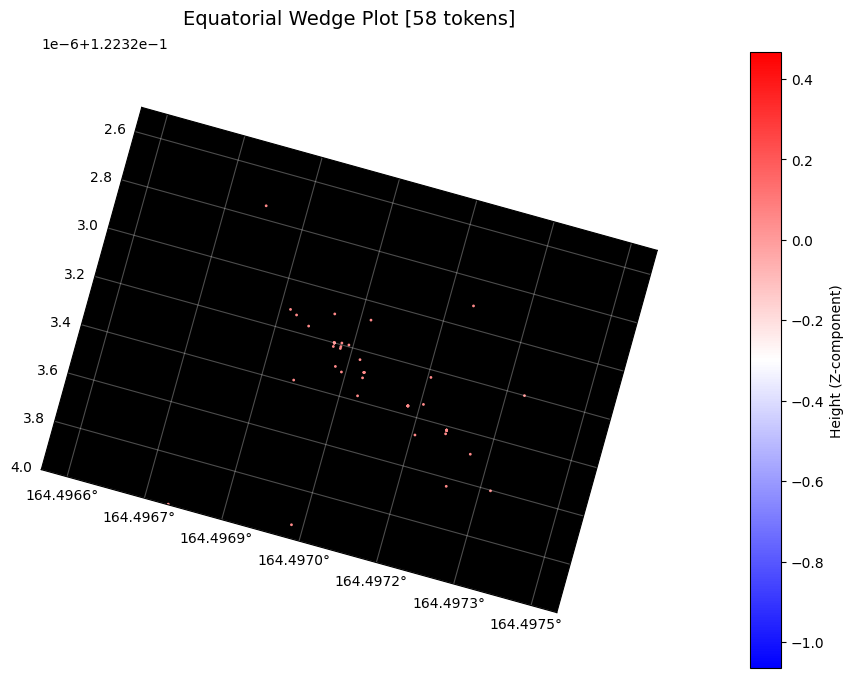

Polar wedge plot complete.



In [819]:
print("Creating polar wedge plot...\n")

# Convert longitude to radians for polar plot
lon_plot_rad = np.deg2rad(lon_plot)
lon_min_rad = np.deg2rad(lon_min)
lon_max_rad = np.deg2rad(lon_max)

# Create figure with polar projection
fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Set theta (angular) limits to show only our wedge
ax.set_thetamin(lon_min)
ax.set_thetamax(lon_max)

# Set radial display range (visible annulus)
# set_ylim controls what radial values are displayed
ax.set_ylim(r_min, r_max)

# Set where radial origin is for coordinate system (keeps geometry correct)
ax.set_rorigin(0)

# Plot points (theta, r order for polar)
if color_mode == 'subset':
    # Plot each subset separately for legend
    unique_subsets = torch.unique(subset_ids[plot_mask])
    for subset_id in unique_subsets:
        subset_idx = subset_ids[plot_mask] == subset_id
        subset_color = SUBSET_COLORS[int(subset_id) % len(SUBSET_COLORS)]
        ax.scatter(lon_plot_rad[subset_idx.cpu().numpy()], r_plot[subset_idx.cpu().numpy()],
                  s=POINT_SIZE, alpha=POINT_ALPHA, c=subset_color,
                  label=f'Subset {int(subset_id)}', rasterized=True)
    ax.legend(loc='upper right', framealpha=0.9)
else:
    # Scalar or Z-height coloring
    # Pin colormap to global range (not just visible data)
    vmin = colors_array.min()
    vmax = colors_array.max()
    
    scatter = ax.scatter(lon_plot_rad, r_plot,
                        s=POINT_SIZE, alpha=POINT_ALPHA, c=colors_plot,
                        cmap=COLORMAP, vmin=vmin, vmax=vmax, rasterized=True)
    cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
    if color_mode == 'z_height':
        cbar.set_label('Height (Z-component)', fontsize=10)
    else:
        cbar.set_label('Color value', fontsize=10)

# Formatting
ax.set_theta_zero_location('N')  # 0° at north (top)
ax.set_theta_direction(1)  # Counter-clockwise (east to the right)
ax.grid(True, alpha=0.3, color='white')

# Title with filter info
filter_note = f" [{n_plotted:,} tokens]"
ax.set_title(f'Equatorial Wedge Plot{filter_note}',
             fontsize=14, pad=20)

plt.show()

print("Polar wedge plot complete.")
print()

## Step 9: Create Density Heatmap

Creating density heatmap...

Binning strategy:
  Angular bin size: 0.01° per bin
  FOV range: 0.0°
  Angular bins in FOV: 1

  Typical radius: 0.122323
  Arc length at typical radius: 0.000021
  Radial bin size (matched): 0.000021
  Radial range: 0.000002
  Radial bins: 1

Density grid: (1, 1)
  Total counts: 58 (should be 58)
  Max density: 58 tokens per bin
  Min density: 58 tokens per bin



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_6391/218857947.py:94: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


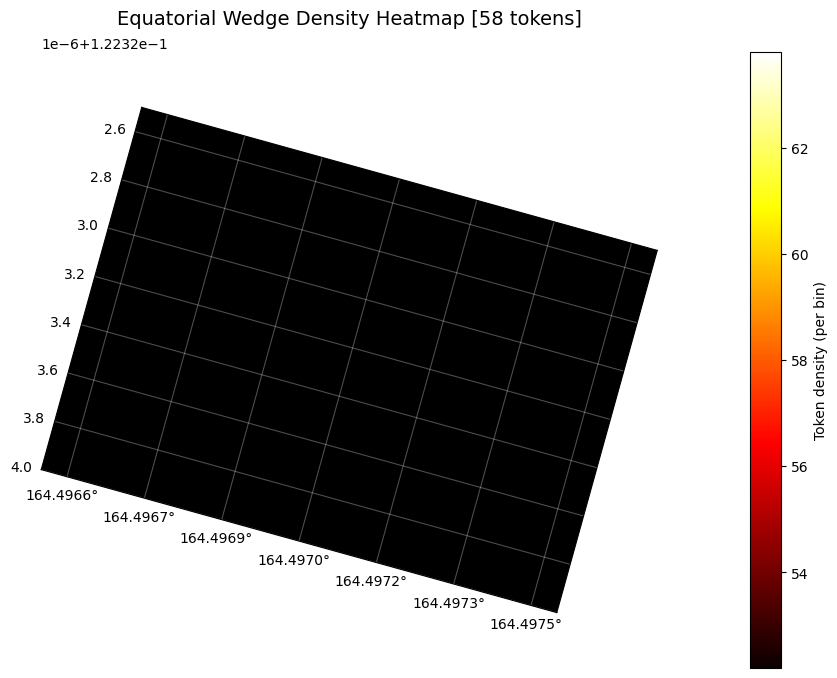

Density heatmap complete.



In [820]:
print("Creating density heatmap...\n")

# Calculate consistent bin size based on full circle
bin_size_angular = 360.0 / DENSITY_BINS_ANGULAR  # e.g., 2° per bin for 180 bins

# Calculate how many angular bins we need for our FOV
fov_range = lon_max - lon_min
n_bins_angular_fov = int(np.ceil(fov_range / bin_size_angular))

# Calculate radial bin size to match angular arc length (for "square" bins)
typical_radius = (r_min + r_max) / 2
angular_bin_rad = np.deg2rad(bin_size_angular)
radial_bin_size = typical_radius * angular_bin_rad

# Calculate how many radial bins we need
radial_range = r_max - r_min
n_bins_radial = max(1, int(np.ceil(radial_range / radial_bin_size)))

print(f"Binning strategy:")
print(f"  Angular bin size: {bin_size_angular:.2f}° per bin")
print(f"  FOV range: {fov_range:.1f}°")
print(f"  Angular bins in FOV: {n_bins_angular_fov}")
print()
print(f"  Typical radius: {typical_radius:.6f}")
print(f"  Arc length at typical radius: {typical_radius * angular_bin_rad:.6f}")
print(f"  Radial bin size (matched): {radial_bin_size:.6f}")
print(f"  Radial range: {radial_range:.6f}")
print(f"  Radial bins: {n_bins_radial}")
print()

# Adjust longitude for histogram if we're wrapping across ±180° boundary
lon_plot_hist = lon_plot.copy()
if lon_max > 180:
    # We're displaying angles > 180° (e.g., 345°)
    # Shift any negative angles by +360° so they fall in the right bins
    lon_plot_hist[lon_plot_hist < 0] += 360

# Create 2D histogram over FOV only, with square-ish bins
hist, lon_edges, r_edges = np.histogram2d(
    lon_plot_hist, r_plot,
    bins=[n_bins_angular_fov, n_bins_radial],
    range=[[lon_min, lon_max], [r_min, r_max]]
)

# Apply Gaussian smoothing if requested
if DENSITY_SMOOTH is not None:
    hist = gaussian_filter(hist, sigma=DENSITY_SMOOTH)

print(f"Density grid: {hist.shape}")
print(f"  Total counts: {hist.sum():.0f} (should be {n_plotted:,})")
print(f"  Max density: {hist.max():.0f} tokens per bin")
print(f"  Min density: {hist.min():.0f} tokens per bin")
print()

# Create meshgrid of bin centers
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
r_centers = (r_edges[:-1] + r_edges[1:]) / 2
lon_grid, r_grid = np.meshgrid(lon_centers, r_centers)

# Convert to radians for polar plot
lon_grid_rad = np.deg2rad(lon_grid)

# Create figure with polar projection
fig = plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT), dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Set theta (angular) limits
ax.set_thetamin(lon_min)
ax.set_thetamax(lon_max)

# Set radial limits
ax.set_ylim(r_min, r_max)
ax.set_rorigin(0)

# Plot heatmap (transpose hist because pcolormesh expects [r, lon] indexing)
mesh = ax.pcolormesh(lon_grid_rad, r_grid, hist.T,
                     cmap=DENSITY_COLORMAP, shading='auto', rasterized=True)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, pad=0.1)
cbar.set_label('Token density (per bin)', fontsize=10)

# Formatting
ax.set_theta_zero_location('N')  # 0° at north (top)
ax.set_theta_direction(1)  # Counter-clockwise
ax.grid(True, alpha=0.3, color='white')

# Title
filter_note = f" [{n_plotted:,} tokens]"
ax.set_title(f'Equatorial Wedge Density Heatmap{filter_note}',
             fontsize=14, pad=20)

plt.tight_layout()
plt.show()

print("Density heatmap complete.")
print()

## Summary

In [821]:
print("=" * 60)
print("EQUATORIAL WEDGE PLOT SUMMARY")
print("=" * 60)
print()
print(f"Input: {VECTORS_FILE}")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()
print(f"Basis: {BASIS_FILE}")
print(f"  North (+Z): {BASIS_KEYS['north']}")
print(f"  Meridian (+X): {BASIS_KEYS['meridian']}")
print(f"  Equinox (+Y): {BASIS_KEYS['equinox']}")
print()
if viewpoint is not None:
    print(f"Viewpoint: {VIEWPOINT_FILE}")
else:
    print("Viewpoint: origin")
print()
print(f"View window:")
print(f"  Longitude: {LOOKAT_LON:.1f}° ± {FOV_DIAMETER/2:.1f}° = [{lon_min:.1f}°, {lon_max:.1f}°]")
print(f"  Radius: [{r_min:.6f}, {r_max:.6f}]")
print()
print(f"Color mode: {color_mode}")
if color_mode == 'subset':
    print(f"  Subsets: {len(torch.unique(subset_ids))}")
elif color_mode == 'scalar':
    print(f"  Custom scalar field")
    print(f"  Colormap: {COLORMAP}")
elif color_mode == 'z_height':
    print(f"  Z-component (height above equatorial plane)")
    print(f"  Colormap: {COLORMAP}")
print()
print(f"Points plotted: {n_plotted:,} (of {N:,} total)")
print(f"Points filtered: {n_filtered:,}")
if n_masked_input > 0:
    print(f"  - Input mask: {n_masked_input:,}")
if n_lon_filtered > 0:
    print(f"  - Longitude filter: {n_lon_filtered:,}")
if n_r_filtered > 0:
    print(f"  - Radius filter: {n_r_filtered:,}")
print()
print("=" * 60)

EQUATORIAL WEDGE PLOT SUMMARY

Input: gamma_qwen3_4b_instruct_2507.safetensors
  Tokens: 151,936
  Dimensions: 2,560

Basis: pca_basis_vectors.safetensors
  North (+Z): 1
  Meridian (+X): 2
  Equinox (+Y): 3

Viewpoint: gamma_centroid_mu.safetensors

View window:
  Longitude: 164.5° ± 0.0° = [164.5°, 164.5°]
  Radius: [0.122323, 0.122324]

Color mode: z_height
  Z-component (height above equatorial plane)
  Colormap: bwr

Points plotted: 58 (of 151,936 total)
Points filtered: 151,878
  - Input mask: 2,100
  - Longitude filter: 149,772
  - Radius filter: 149,774

